# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Team:** Group 5  
**Authors:** Chun-Hung Yeh, Kuan Tung, Zhuoyue Wang  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import cv2
import scipy.ndimage
from skimage import measure
from skimage.color import rgb2gray
from skimage.segmentation import active_contour
from skimage.morphology import remove_small_objects
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

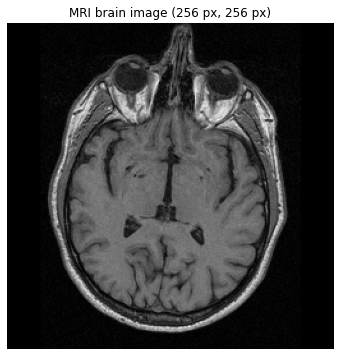

In [2]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

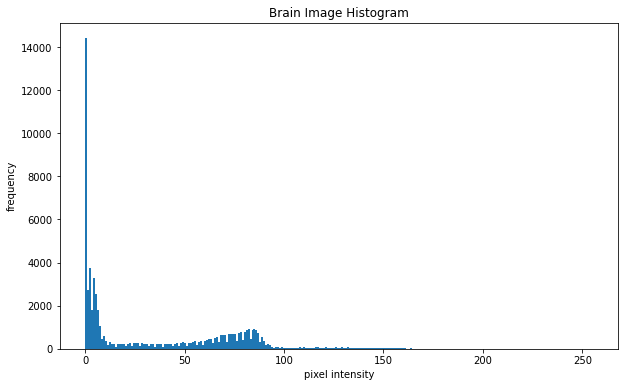

In [3]:
# check the pixel histogram of the image
plt.figure(figsize = (10, 6))
plt.hist(brain_im.ravel(), bins = 256, range = (0, 255))
plt.xlabel('pixel intensity')
plt.ylabel('frequency')
plt.title('Brain Image Histogram')
plt.show()

**Explanation**
- From the above plot, the image histogram is bimodal, which can be divided into two groups. One is for background, and the other is for the brain.
- Most pixels in one group have low values around 0, reflecting that they belong to the background.
- Thus, the pixels with the intensity around 50 to 100 now belong to the brain.

#### ***Region-growing Algorithm Explained***
Region growing is a pixel-based segmentation method which involves the selection of initial seed points. The approach examines neighboring points of initial seed points and determines if the pixel neighbors should be added. The key problem is thresholding, choosing the best threshold value to minimize the probability of wrong classification. By trials and errors, we could find out a suitable threshold for separating the distribution of these groups. 

In [4]:
# region growing function
def region_grow(img, threshold, start_point):
    def grow(x_start, y_start, image, threshold, pixels, img_mask):
        pixel = []
        im_w, im_h = image.shape
        pixel_new = [[x_start+i, y_start+j] for i in range(-1, 2) for j in range(-1, 2)  if x_start+i in range(im_w) and y_start+j in range(im_h) if i != j]
        for t in pixel_new:
            x, y = t
            if np.abs(int(image[x, y])-int(image[x_start, y_start])) < threshold and t not in pixels:
                if t not in pixel:
                    pixel.append(t)
                    img_mask[t[0], t[1]] = image[t[0], t[1]]
        return pixel, img_mask
    
    im_w, im_h = img.shape
    pixel = [[i, j] for i in range(im_w) for j in range(im_h)]
    pixel_same = [start_point]
    size = 1
    pixels = []
    img_mask = np.zeros(img.shape)
    img_mask[start_point[0],start_point[1]] = img[start_point[0],start_point[1]]
    while(len(pixel_same) > 0):
        pixel_iter = []
        for i in pixel_same:
            x_start, y_start = i
            a, img_mask = grow(x_start, y_start, img, threshold, pixels, img_mask)
            pixels = pixels + a
            pixel_iter += a
        pixel_same = pixel_iter
    return img_mask

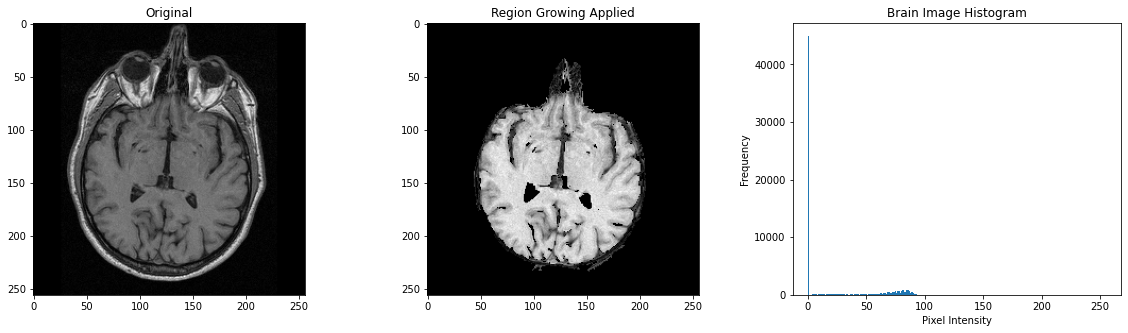


Brain size: 18171 pixels


In [5]:
# apply region-growing method with threshold equal to 10 (<-- trial and error)
brain_image = region_grow(brain_im, 10, [128,128])

# visualize
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(brain_im, 'gray')
ax[0].set_title('Original')
ax[1].imshow(brain_image, 'gray')
ax[1].set_title('Region Growing Applied')
ax[2].hist(brain_image.ravel(), bins = 256, range = (0, 255))
ax[2].set_title('Brain Image Histogram')
ax[2].set_xlabel('Pixel Intensity')
ax[2].set_ylabel('Frequency')
plt.show()

# denoise with threshold == 30
brain_image[brain_image < 30] = 0

# compute the size
pixels = sum(sum(brain_image >= 30))
print('\nBrain size: ' + str(pixels) + ' pixels')

**Explanation**
- We select the pixel at (128, 128) as the initial seed point.
- Since the brain histogram follows the heavily right-skewed distribution, we assume that the threshold would be located around 0. Following several trials, we find out the optimal threshold is 10.
- Thus, using region growing we get the brain size equal to 18171 pixels (use this as our benchmark).

# 1.3 Contour detection
Add your implementation and discussion

#### **Inverse method + thresholding**
This method basically applies the inverse of the image to find the brain edges. Specifically, we iterate through the pixels with nonzero values to set the outside of the brain to a high value. As a result, the edges of the brain can be found. Lastly, according to the histogram, we pick a threshold for computation of the brain size.

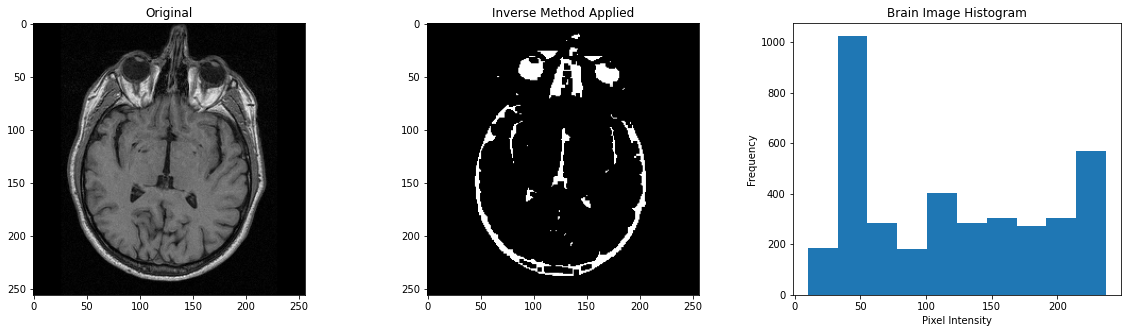

In [6]:
brain_new_image = np.copy(brain_im)

# reduce noise
brain_new_image[brain_new_image < 30] = 0 

# set the outside of the brain to 255
for i in range(len(brain_new_image[:, 1])):
    if len(brain_new_image[i, :].nonzero()[0]) > 0:
        brain_new_image[i, :][np.max(brain_new_image[i,:].nonzero()): 255] = 80
        brain_new_image[i, :][0: np.min(brain_new_image[i,:].nonzero())] = 80
    else:
        brain_new_image[i,:] = 80

brain_new_image[brain_new_image > 30] = 80
brain_new = np.invert(brain_new_image)
brain_new = scipy.ndimage.grey_closing(brain_new,size = (3, 3))
brain_new = scipy.ndimage.grey_erosion(brain_new,size = (2, 2))
brain_new[brain_new < 200] = 0

# visualize brain and its histogram
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(brain_im, 'gray')
ax[0].set_title('Original')
ax[1].imshow(brain_new, 'gray')
ax[1].set_title('Inverse Method Applied')
ax[2].hist(list(brain_new.nonzero()[0]))
ax[2].set_title('Brain Image Histogram')
ax[2].set_xlabel('Pixel Intensity')
ax[2].set_ylabel('Frequency')
plt.show()

From the histogram, we can see the pixel discrete at around 90.

In [7]:
# compute the size
pixels, a = 0, 0
for i in range(90, 255):
    if len(brain_new[i,:].nonzero()[0]) > 0:
        a = np.max(brain_new[i,:].nonzero())-np.min(brain_new[i,:].nonzero())
        pixels += a
print('Brain size: ' + str(pixels) + ' pixels')

Brain size: 19672 pixels


**Explanation**
- The histogram is bimodal as well.
- Based on the histogram, we choose the threshold to be around 90. And this could be the optimal threshold to best extract the brain from the rest in the image.
- Finally, the brain size is 19672 pixels, which is a little bit larger than the one using region growing. We speculate that the contour has a width and we include the pixels inside the curvatures, so that's why it's bigger. 

### 1.4 Additional method(s)
Add your implementation and discussion

#### **Method 1: Robert Operator**
Robert operator is used to detect edges by applying a horizontal and verticle filter in a sequence. Both filters are applied to the image and summed to form the final result. The two filters are basic convolution filters of the form: 
$$h_{1} = \begin{bmatrix} 1 & 0 \\ 0 & -1\end{bmatrix},\; h_{2} = \begin{bmatrix} 0 & 1 \\ -1 & 0\end{bmatrix}$$

Robert operator is fast because the filters are small but they are subject to interference by noise. If edges are not very sharp the filters will tend not to detect the edge. 

In [8]:
# Robert Operator
def robert(img):
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[1, 0], [0, -1]]) # h1
    vertical = np.array([[0, 1], [-1, 0]]) # h2 

    # define images with 0s
    newhorizontalImage = np.zeros((h, w))
    newverticalImage = np.zeros((h, w))
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j])

            newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j])

            newverticalImage[i - 1, j - 1] = abs(verticalGrad)

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage = scipy.ndimage.grey_closing(newgradientImage, size = (3, 3))
            newgradientImage[newgradientImage < 75] = 0

    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage, cmap='gray')
    ax[1].set_title('Robert Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()
    
    # compute the size
    pixels, a = 0, 0
    for i in range(115, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

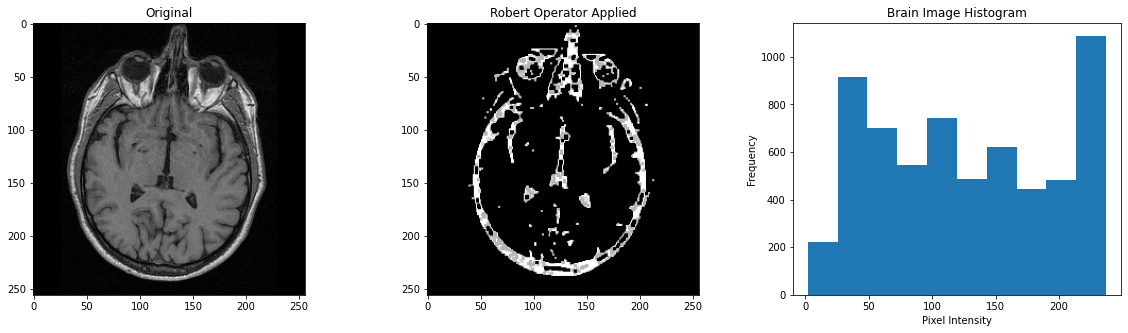


Brain size: 16842 pixels


In [9]:
# apply the Robert operator for contour detection
robert(brain_new_image)

#### **Explanation**
- The histogram approximately follows the bimodal distribution.
- By trials and errors, we select the threshold at 115.
- It turns out the predicted brain size is smaller than the previous two methods.

#### **Method 2: Sobel Operator**
Sobel operator is the most commonly used operator for edge detection. Similar to Robert operator, it is based on convolving the image with a small, separable, and integer-valued filters in horizontal and vertical direction and is therefore relatively inexpensive in terms of computations. Its filter form: 

$$h_{1} = \begin{bmatrix} 1 & 2 & 1\\ 0 & 0 & 0\\ -1 & -2 & -1\end{bmatrix},\; h_{2} = \begin{bmatrix}-1 & 0 & 1\\ -2 & 0 & 2\\ -1 & 0 & 1\end{bmatrix}$$

However, Sobel operator also provides differentiating (which gives the edge response) and smoothing (which reduces noise) concurrently.

In [10]:
# Sobel Operator
def sobel(img):
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) # h1
    vertical = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # h2

    # define images with 0s
    newhorizontalImage = np.zeros((h, w))
    newverticalImage = np.zeros((h, w))
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[0, 2] * img[i - 1, j + 1]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j]) + \
                             (horizontal[1, 2] * img[i, j + 1]) + \
                             (horizontal[2, 0] * img[i + 1, j - 1]) + \
                             (horizontal[2, 1] * img[i + 1, j]) + \
                             (horizontal[2, 2] * img[i + 1, j + 1])

            newhorizontalImage[i - 1, j - 1] = abs(horizontalGrad)

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[0, 2] * img[i - 1, j + 1]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j]) + \
                           (vertical[1, 2] * img[i, j + 1]) + \
                           (vertical[2, 0] * img[i + 1, j - 1]) + \
                           (vertical[2, 1] * img[i + 1, j]) + \
                           (vertical[2, 2] * img[i + 1, j + 1])

            newverticalImage[i - 1, j - 1] = abs(verticalGrad)

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage = scipy.ndimage.grey_closing(newgradientImage, size = (3, 3))
            newgradientImage[newgradientImage < 75] = 0

    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage, cmap='gray')
    ax[1].set_title('Sobel Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()
    
    # compute the size
    pixels, a = 0, 0
    for i in range(141, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

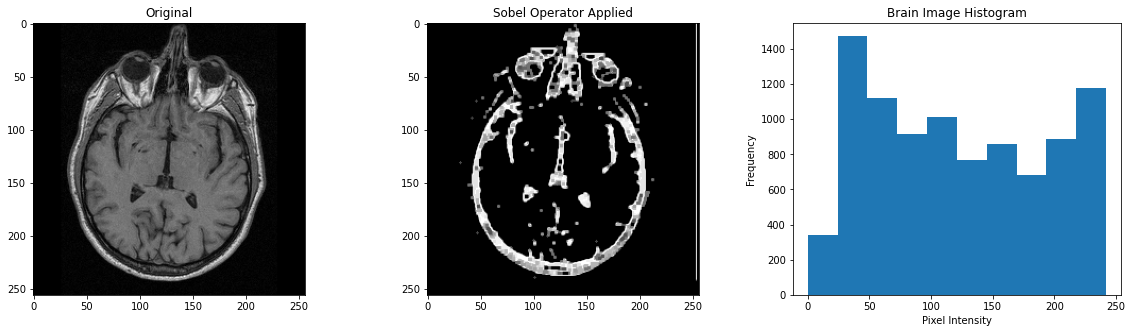


Brain size: 19432 pixels


In [11]:
sobel(brain_new_image)

#### **Explanation**
- The image histogram is bimodal roughly.
- Since this is not a sharply skewed bimodal distribution, the threshold could be in the range [100, 200]. Here we pick the value at 141.
- The brain size is slightly larger than the benchmark, which could result from that we include the contours.

#### **Method 3: Prewitt Operator**
Prewitt operator is similar to Sobel operator and is used for detecting vertical and horizontal edges in images. Yet, unlike the Sobel, this operator does not place any emphasis on the pixels that are closer to the center of the mask. Its form is:

$$h_{1} = \begin{bmatrix} 0 & 1 & 1\\ -1 & 0 & 1\\ -1 & -1 & 0\end{bmatrix},\; h_{2} = \begin{bmatrix}-1 & 0 & 1\\ -1 & 0 & 1\\ -1 & 0 & 1\end{bmatrix}$$

In [12]:
# Prewitt Operator
def prewitt(img): 
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[0, 1, 1], [-1, 0, 1], [-1, -1, 0]]) # h1
    vertical = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]) # h2

    # define images with 0s
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[0, 2] * img[i - 1, j + 1]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j]) + \
                             (horizontal[1, 2] * img[i, j + 1]) + \
                             (horizontal[2, 0] * img[i + 1, j - 1]) + \
                             (horizontal[2, 1] * img[i + 1, j]) + \
                             (horizontal[2, 2] * img[i + 1, j + 1])

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[0, 2] * img[i - 1, j + 1]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j]) + \
                           (vertical[1, 2] * img[i, j + 1]) + \
                           (vertical[2, 0] * img[i + 1, j - 1]) + \
                           (vertical[2, 1] * img[i + 1, j]) + \
                           (vertical[2, 2] * img[i + 1, j + 1])

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage[newgradientImage < 75] = 0
            
    fig, ax = plt.subplots(1, 3, figsize = (20, 8))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage.astype('uint8'), cmap='gray')
    ax[1].set_title('Prewitt Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()

    # compute the size
    pixels, a = 0, 0
    for i in range(140, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

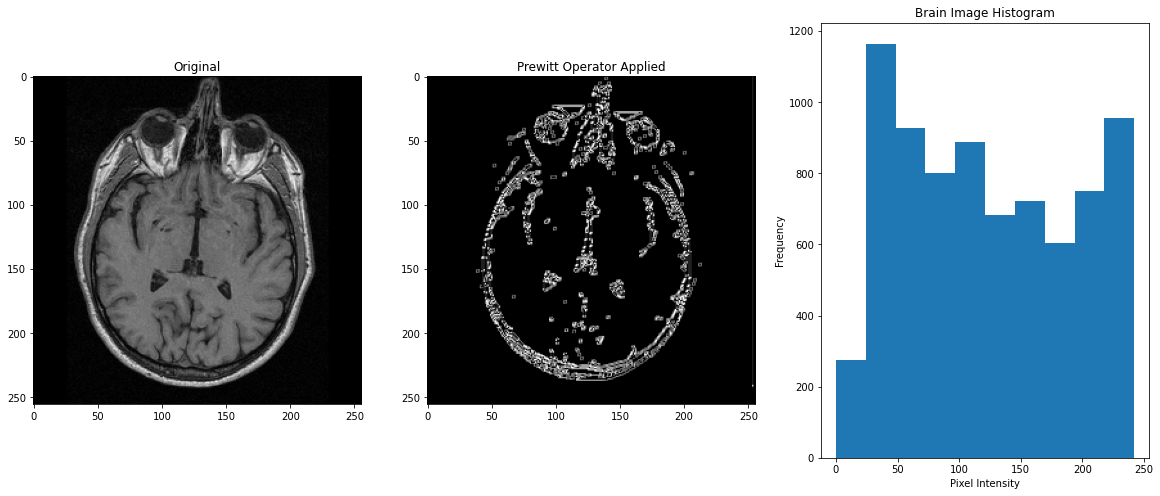


Brain size: 19159 pixels


In [13]:
prewitt(brain_new_image)

#### **Explanation**
- Similar reason as the previous method, the histogram again is bimodal (not very apparent though).
- Here we pick the threshold at 140 so that the brain size prediction is 19159 pixels.

#### **Method 4: Laplacian**
Unlike the Sobel and Prewitt’s operators, Laplacian operator calculates second order derivatives in a single pass. Two commonly used small kernels are: 

$$h_{1} = \begin{bmatrix} 0 & -1 & 0\\ -1 & 4 & -1\\ 0 & -1 & 0\end{bmatrix},\; h_{2} = \begin{bmatrix}-1 & -1 & -1\\ -1 & 8 & 1\\ -1 & -1 & -1\end{bmatrix}$$

Because these masks are approximating a second derivative measurement on the image, they are very sensitive to noise. To correct this, the image is often Gaussian smoothed before applying the Laplacian filter.

In [14]:
# Laplacian Operator
def laplacian(img): 
    h, w = img.shape
    
    # define filters
    horizontal = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) # h1
    vertical = np.array([[-1, -1, -1], [-1, 8, 1], [-1, -1, -1]]) # h2

    # define images with 0s
    newgradientImage = np.zeros((h, w))

    # offset by 1
    for i in range(1, h - 1):
        for j in range(1, w - 1):
            horizontalGrad = (horizontal[0, 0] * img[i - 1, j - 1]) + \
                             (horizontal[0, 1] * img[i - 1, j]) + \
                             (horizontal[0, 2] * img[i - 1, j + 1]) + \
                             (horizontal[1, 0] * img[i, j - 1]) + \
                             (horizontal[1, 1] * img[i, j]) + \
                             (horizontal[1, 2] * img[i, j + 1]) + \
                             (horizontal[2, 0] * img[i + 1, j - 1]) + \
                             (horizontal[2, 1] * img[i + 1, j]) + \
                             (horizontal[2, 2] * img[i + 1, j + 1])

            verticalGrad = (vertical[0, 0] * img[i - 1, j - 1]) + \
                           (vertical[0, 1] * img[i - 1, j]) + \
                           (vertical[0, 2] * img[i - 1, j + 1]) + \
                           (vertical[1, 0] * img[i, j - 1]) + \
                           (vertical[1, 1] * img[i, j]) + \
                           (vertical[1, 2] * img[i, j + 1]) + \
                           (vertical[2, 0] * img[i + 1, j - 1]) + \
                           (vertical[2, 1] * img[i + 1, j]) + \
                           (vertical[2, 2] * img[i + 1, j + 1])

            # Edge Magnitude
            mag = np.sqrt(pow(horizontalGrad, 2.0) + pow(verticalGrad, 2.0))
            newgradientImage[i - 1, j - 1] = mag
            newgradientImage = scipy.ndimage.grey_closing(newgradientImage.astype('uint8'), size = (3, 3))
            newgradientImage[newgradientImage < 220] = 0
            
    fig, ax = plt.subplots(1, 3, figsize = (20,5))
    ax[0].imshow(brain_im, 'gray')
    ax[0].set_title('Original')
    ax[1].imshow(newgradientImage, cmap='gray')
    ax[1].set_title('Laplacian Operator Applied')
    ax[2].hist(newgradientImage.nonzero()[0])
    ax[2].set_title('Brain Image Histogram')
    ax[2].set_xlabel('Pixel Intensity')
    ax[2].set_ylabel('Frequency')
    plt.show()

    # compute the size
    pixels, a = 0, 0
    for i in range(150, 255):
        if len(newgradientImage[i,:].nonzero()[0]) > 0:
            a = np.max(newgradientImage[i, :].nonzero())-np.min(newgradientImage[i, :].nonzero())
            pixels += a
    print('\nBrain size: ' + str(pixels) + ' pixels')

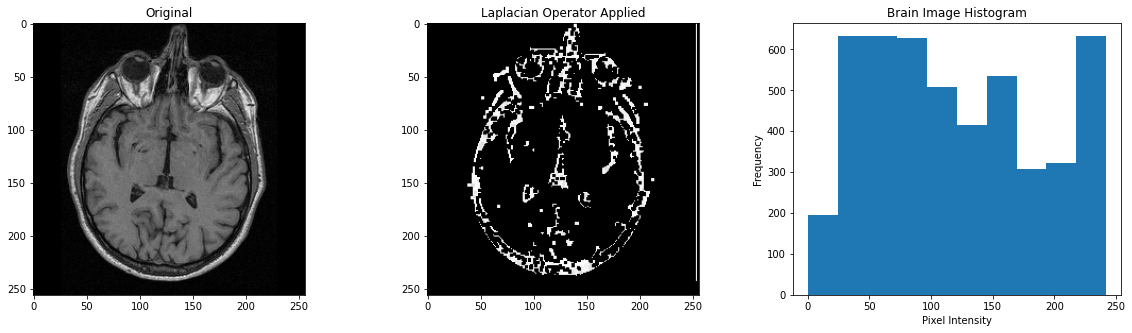


Brain size: 16820 pixels


In [15]:
laplacian(brain_new_image)

**Explanation**
- As shown above, we set the threshold at 150, and the prediction of the size is slightly smaller than the benchmark. 
- We guess it's because the contour using the operator also contain some part of the brain, decreasing the predicted brain size. 

#### **Method 5: Canny Operator**
Canny operator is an edge detection operator using a multi-stage algorithm to detect a wide range of edges in images. Specifically, it does the following: 

1. Smooth the image with a Gaussian filter to reduce noise.
2. Compute gradient of using any of the gradient operators Sobel or Prewitt.
3. Extract edge points: Non-maximum suppression.
4. Linking and thresholding: Hysteresis.

Note that in the third step, we are trying to relate the edge direction to a direction that can be traced along the edges based on the previously calculated gradient strengths and edge directions. At each pixel location we have four possible directions. We check all directions if the gradient is maximum at this point. Perpendicular pixel values are compared with the value in the edge direction. If their value is lower than the pixel on the edge then they are suppressed. After this step we will get broken thin edges that needs to be fixed. Finally, in the fourth step, we iterate over the pixels and check if the current pixel is an edge. If it’s an edge then check surrounding area for edges. If they have the same direction then we mark them as an edge pixel. We also use 2 thresholds, a high and low. If the pixels is greater than lower threshold it is marked as an edge. Then pixels that are greater than the lower threshold and also are greater than high threshold, are also selected as strong edge pixels. When there are no more changes to the image we stop.

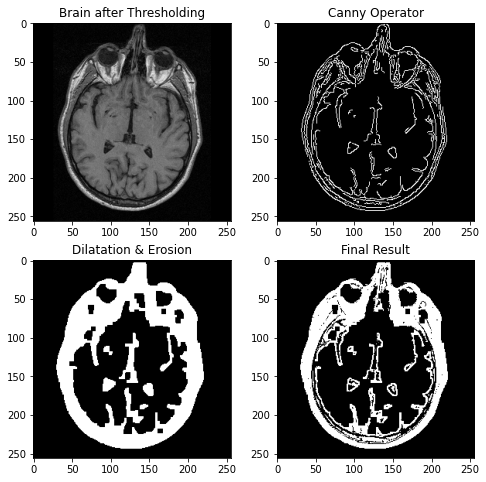

In [16]:
# Apply Canny Operator
# from the histogram of the brain image, the second cluster has threshold at 60 to 90.
brain_new_image_1 = brain_im.copy()
edges = cv2.Canny(brain_new_image_1, 100, 200, 3, L2gradient = True)
brain_di = scipy.ndimage.binary_dilation(edges, structure = np.ones((8,8))).astype('uint8')
brain_di = scipy.ndimage.binary_erosion(brain_di, structure = np.ones((6,6))).astype('uint8')
brain_new_image_2 = brain_new_image.copy()
brain_new_image_2[brain_di==0] = 0

# visualize
plt.figure(figsize = (8, 8))
plt.subplot(2, 2, 1)
plt.imshow(brain_new_image_1, cmap = 'gray')
plt.title('Brain after Thresholding')
plt.subplot(2, 2, 2)
plt.imshow(edges, cmap = 'gray')
plt.title('Canny Operator')
plt.subplot(2, 2, 3)
plt.imshow(brain_di, cmap = 'gray')
plt.title('Dilatation & Erosion')
plt.subplot(2, 2, 4)
plt.imshow(brain_new_image_2, cmap='gray')
plt.title('Final Result')
plt.show()

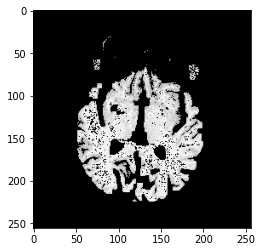


Brain size: 12787 pixels


In [17]:
# extract the brain from the image
temp = brain_im - 2*brain_new_image_2
temp[temp < 100] = 0
temp = np.abs(brain_im - temp)
temp[temp >= 90] = 0
temp[temp <= 60] = 0

plt.imshow(temp, cmap = 'gray')
plt.show()
print('\nBrain size: ' + str(np.sum(temp!=0)) + ' pixels')

**Explanation**
- From the final result, we actually get the well-shaped contour.
- However, our manual denoising method makes us lose some pixels about the brain; thus, the estimated brain size is much smaller than the benchmark.

#### **Method 6: Active Contour, Snake**
The active contour model is a method to fit open or closed splines to lines or edges in an image. It works by minimising an energy that is in part defined by the image and part by the spline’s shape: length and smoothness. The minimization is done implicitly in the shape energy and explicitly in the image energy. Here we first implement the snake operator function to detect the shape of the brain and then use it to estimate the size of the brain.

In [18]:
# Snake Operator
def snake(img, r, gau, g, alpha, beta, w_edge, gamma):
    s = np.linspace(0, 2*np.pi, 400)
    x = 125 + r*np.cos(s)
    y = 150 + r*np.sin(s)
    init = np.array([x, y]).T
    
    if gau:snake = active_contour(gaussian(img,g),init, alpha, beta,w_edge, gamma)
    else:  snake = active_contour(img,init, alpha, beta,w_edge, gamma)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 0], init[:, 1], '--r',  lw=3)
    ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    return snake

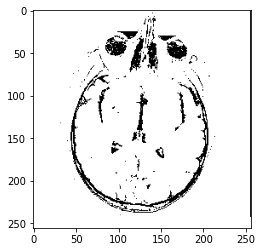

In [19]:
plt.imshow(brain_new_image, 'gray')
plt.show()

/Users/chunhungyeh/opt/anaconda3/envs/iapr2020/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  if __name__ == '__main__':


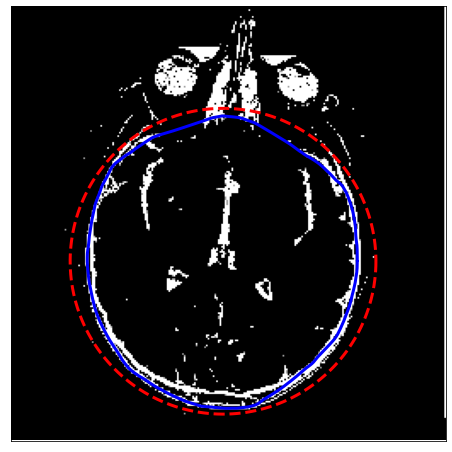

In [20]:
snake_img = snake(np.invert(brain_new_image), r = 90, gau = False, g = 0.1, alpha = 0.2, beta = 0.01, w_edge = 0.1, gamma = 0.01)

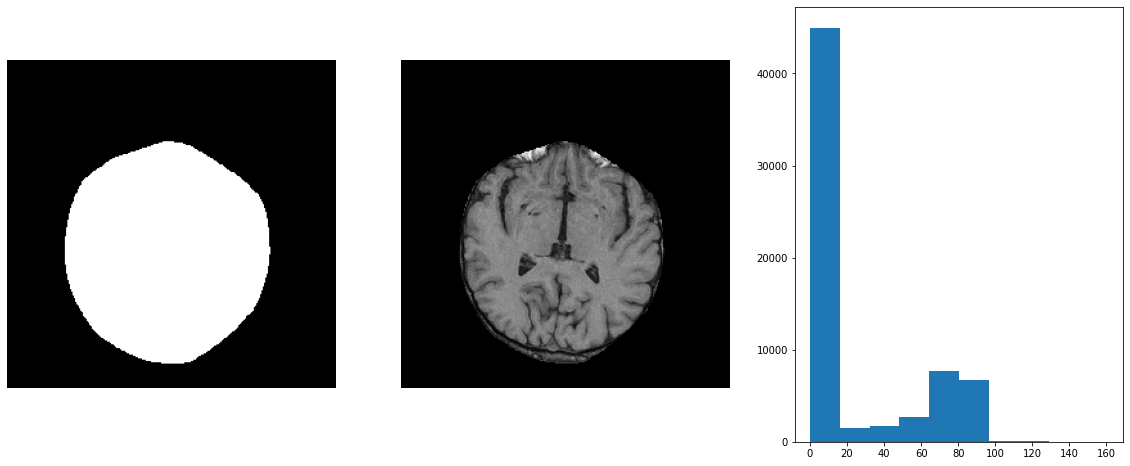


Brain size: 19164 pixels


In [21]:
# extract the area in the contour
snake_img_int = snake_img.astype(int)
mask = cv2.drawContours(np.zeros(brain_im.shape), [snake_img_int], 0, 1, -1)
brain_area = brain_im * mask

# visualize
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(mask, cmap=plt.cm.gray)
ax[0].axis('off')
ax[1].imshow(brain_area, cmap=plt.cm.gray)
ax[1].axis('off')
ax[2].hist(brain_area.ravel())
plt.show()

# compute the size of the brain
# from the histogram, we choose 30 as threshold to calculate the number of pixels
threshold = 30;
size = sum(sum(brain_area > 30))
print('\nBrain size: ' + str(size) + ' pixels')

**Explanation**
- The size is a little bigger than we calculate in the former part. It's because the snake contour does not catch the specific contour of the brain. Instead, it only catches the edge of the simple geometric shape of the brain.

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [22]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


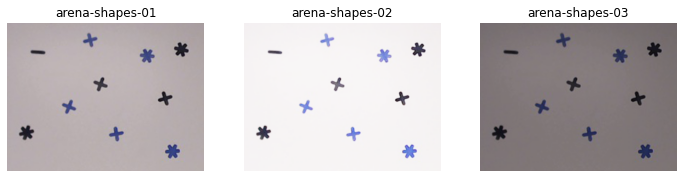

In [23]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Our routine is straightforward. We first detect the contour of the shapes, and then decide what color are those shapes. We will show our implementation detail in the following cells.

In order to get a better contour detection, we perform a series of preprocessing:  

1. Convert the image to grayscale because we will not use color information when detecing contours.
2. Adaptively threshold the image. The threshold is computed for each small region by subtracting a constant C (the last argument) from the gaussian-weighted sum of the neighborhood values. We set the constant C = 2 and neighborhood size = 51 by trial and error. It will give a better result compared to fixed thresholding.
3. Make the foreground white and the background black by inverting the image.
4. Use morphology to remove small objects and fill small holes so that we can get a correct segmentation of foreground and background. We set the minimum size = 100.

In [24]:
def preprocess(image):
    """Preprocess the image for better contour detection.
    
    Args:
        image (numpy.ndarray): The input image.
    Return:
        numpy.ndarray: A black and white version of the input image with low noise.
    """
    # convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # adaptively threshold the image
    th_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 2)
    # invert the image
    inv_th_image = ~th_image
    # remove small noises using morphology
    clean_image = remove_small_objects(inv_th_image.astype(bool), min_size=100)
    # fill holes using morphology
    filled_image = scipy.ndimage.binary_fill_holes(clean_image).astype(np.uint8)
    return filled_image

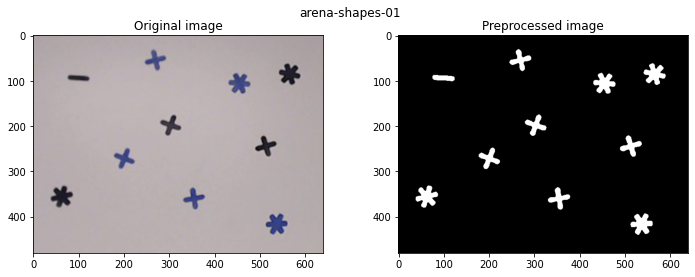

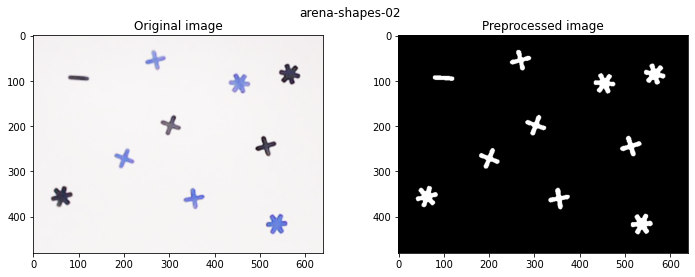

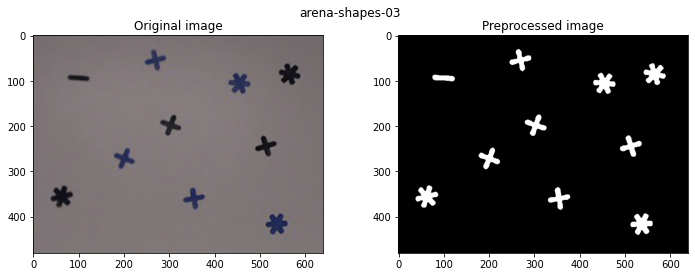

In [25]:
# plot the preprocessed images
for i in range(3):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(im_names[i])
    axes[0].imshow(images[i])
    axes[0].set_title('Original image')
    axes[1].imshow(preprocess(images[i]), cmap='gray')
    axes[1].set_title('Preprocessed image')

The foreground and background of all three images are nicely separated.  This will be useful when detecting contours.
___

Since our routine has to be robust to illumination changes, we normalize the image to make intensities of the images comparable:  

1. We use [Yen's method](https://doi.org/10.1109/83.366472) to find a threshold value that separates the distribution in the intensity histogram.
2. Rescale the intensity with the threshold value.

In [26]:
def normalize(image):
    """Normalize the image to handle illumination differences.
    
    Args:
        image (numpy.ndarray): The input image.
    Return:
        numpy.ndarray: A normalized image in terms of intensity.
    """
    # get the threshold using Yen's method
    yen_threshold = threshold_yen(image)
    # rescale the intensity with the threshold
    normalized = rescale_intensity(image, (0, yen_threshold), (0, 255))
    
    return normalized

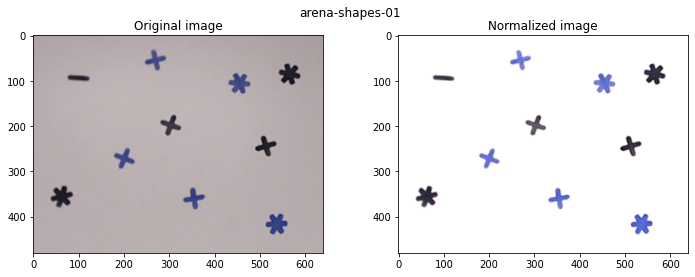

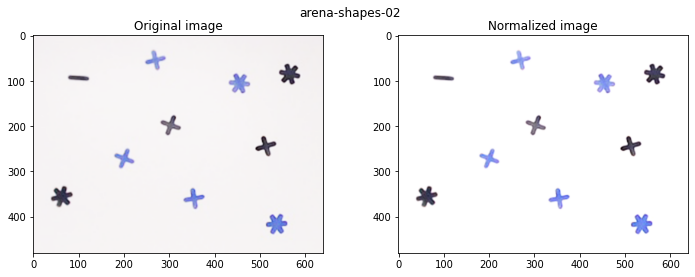

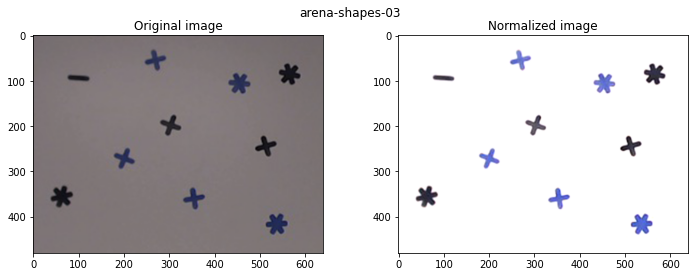

In [27]:
# plot the normalized images
for i in range(3):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(im_names[i])
    axes[0].imshow(images[i])
    axes[0].set_title('Original image')
    axes[1].imshow(normalize(images[i]))
    axes[1].set_title('Normalized image')

The illumination differences in the normalized images are less than the ones in the original images.
___

When detecting the color of a shape, we only look at one of the pixel since all the shapes have uniformly distributed colors.  

We convert the image to HSV (Hue, Saturation and Value) representation and check whether the value of a point is within a predefined range belonged to a certain color. The reason we do it in HSV is because we can much easily separate colors with hue (one value instead of three values, RGB). We still need to look at saturation and brightness to separate black from other colors.

In [28]:
# these ranges are set by trial and error
color_range = {
    'blue': [(100, 90, 140), (130, 255, 255)],
    'black': [(0, 0, 0), (179, 90, 140)]
}

In [29]:
def detect_color(image, pixel, color_range=color_range):
    """Detect the color of a pixel in the image.
    
    Args:
        image (numpy.ndarray): The input image.
        pixel (tuple): The position you want to detect the color.
        color_range (dict): The accepted range (in HSV) for all the considered colors.
    Return:
        str: The name of the color.
    """
    # set a default color the prevent error when no color is detected
    color = list(color_range.keys())[0]
    # convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # loop through the color we want to detect
    for key, range_ in color_range.items():
        # use the color range (in HSV) to set up a mask
        mask = cv2.inRange(hsv_image, range_[0], range_[1])
        # the pixel is within the range of the color
        if mask[pixel] == 255:
            color = key
            break
    return color

The color of the pixel (indicated by the red dot) in the following image is black


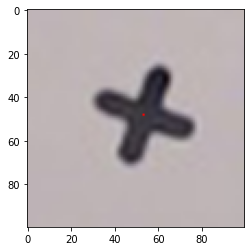

In [30]:
# an example to show detect_color works
tmp = images[0].copy()
tmp[198, 303] = [255, 0, 0]
# plot a part of the image
plt.imshow(tmp[150:250, 250:350])
print(f'The color of the pixel (indicated by the red dot) in the following image is {detect_color(images[0], (198, 303))}')

Finally, we combine all the functions and perform our main task:  

1. Preprocess the image.
2. Use `cv2.findContours` to get all the contours. `cv2.RETR_LIST` is set because we don't need hierarchical relationships. `cv2.CHAIN_APPROX_SIMPLE` is set because it will save a lot of memory without any major disadvantage. The details of these two mode are shown in the next cell.
3. For each contours, we use `cv2.moments` to find the centroid of the shape and detect the color of it. Here we use the normalized image as input.
4. We can now count how many shapes of each color and visualize the result.

The following descriptions were copied from the [document](https://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) of OpenCV:  
`cv2.RETR_LIST`: retrieves all of the contours without establishing any hierarchical relationships.  
`cv2.CHAIN_APPROX_SIMPLE`: compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, an up-right rectangular contour is encoded with 4 points.

In [31]:
def count_shapes(image, color_range=color_range):
    """Count the number of shapes of each color in the image.
    
    Args:
        image (numpy.ndarray): The input image.
        color_range (dict): The accepted range (in HSV) for all the considered colors.
    """
    # copy the image for the final visualization
    image_copy = image.copy()
    # counter dictionary to store how many shapes of each color
    shapes_ctn = {key: 0 for key in color_range.keys()}
    
    # preprocess the image
    preprocessed_image = preprocess(image)
    # get the contours of all shapes
    _, contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    print(f'Total number of shapes: {len(contours)}')
    
    for c in contours:
        # compute the centroid of the shapes
        M = cv2.moments(c)
        cY = int(M['m01'] / M['m00'])
        cX = int(M['m10'] / M['m00'])
        center = (cY, cX)
        
        # detect the color color of the centroid
        color = detect_color(normalize(image), center)
        shapes_ctn[color] += 1
        
        # visualize the result on the image
        label_color = (214, 39, 40)
        cv2.drawContours(image_copy, [c], 0, label_color, 2)
        cv2.putText(image_copy, color, (cX, cY + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, label_color, 2)
        
    for color in color_range.keys():
        print(f'Number of {color} shapes: {shapes_ctn[color]}')
        
    plt.imshow(image_copy)
    plt.show()

---------------------------------------------
Counting shapes for arena-shapes-01

Total number of shapes: 10
Number of blue shapes: 5
Number of black shapes: 5


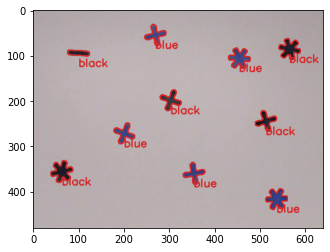

---------------------------------------------
Counting shapes for arena-shapes-02

Total number of shapes: 10
Number of blue shapes: 5
Number of black shapes: 5


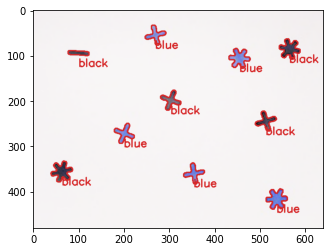

---------------------------------------------
Counting shapes for arena-shapes-03

Total number of shapes: 10
Number of blue shapes: 5
Number of black shapes: 5


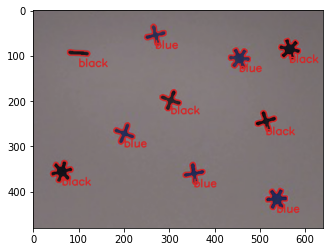

In [32]:
for i in range(3):
    print('-' * 45)
    print(f'Counting shapes for {im_names[i]}')
    print()
    count_shapes(images[i])

Our routine can successfully count the number of shapes of each color.
___

### 2.3 Total area (in pixels) of each color
For computing the total area of each color, we mostly follow the same processes as the previous part. The only difference is we use `cv2.contourArea` to compute the area of each shape.

In [33]:
def compute_area(image, color_range=color_range):
    """Compute the total area of each color in the image.
    
    Args:
        image (numpy.ndarray): The input image.
        color_range (dict): The accepted range (in HSV) for all the considered colors.
    """
    # copy the image for the final visualization
    image_copy = image.copy()
    # dictionary to store the area of each color
    area_ctn = {key: 0 for key in color_range.keys()}
    
    # preprocess the image
    preprocessed_image = preprocess(image)
    # get the contours of all shapes
    _, contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        # compute the centroid of the shapes
        M = cv2.moments(c)
        cY = int(M['m01'] / M['m00'])
        cX = int(M['m10'] / M['m00'])
        center = (cY, cX)
        
        # detect the color color of the centroid
        color = detect_color(normalize(image), center)
        # compute the area and save it
        area = int(cv2.contourArea(c))
        area_ctn[color] += area
        
        # visualize the result on the image
        label_color = (214, 39, 40)
        cv2.drawContours(image_copy, [c], 0, label_color, 2)
        cv2.putText(image_copy, color, (cX, cY + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, label_color, 2)
        cv2.putText(image_copy, str(area), (cX, cY + 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, label_color, 2)
        
    for color in color_range.keys():
        print(f'Total area (in pixels) of {color} shapes: {area_ctn[color]}')
        
    plt.imshow(image_copy)
    plt.show()

---------------------------------------------
Computing area for arena-shapes-01

Total area (in pixels) of blue shapes: 5020
Total area (in pixels) of black shapes: 4655


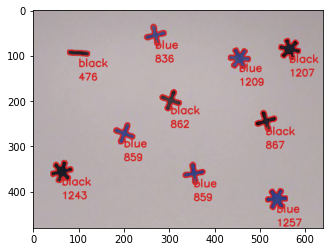

---------------------------------------------
Computing area for arena-shapes-02

Total area (in pixels) of blue shapes: 4430
Total area (in pixels) of black shapes: 4125


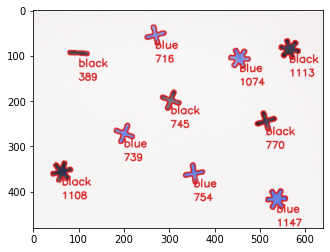

---------------------------------------------
Computing area for arena-shapes-03

Total area (in pixels) of blue shapes: 5100
Total area (in pixels) of black shapes: 4739


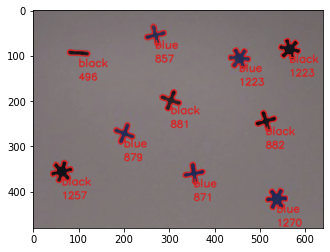

In [34]:
for i in range(3):
    print('-' * 45)
    print(f'Computing area for {im_names[i]}')
    print()
    compute_area(images[i])

It seems like the darker the image is, the more pixels will be counted. The reason could be because in a darker image, the background is darker. The contour finding function will include more pixels since blue and black shapes are more similar to the background.
___